In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.chdir("".join((os.getcwd().split("PCNN")[0], "/PCNN/src/")))
#import run_core as rc
#import utils_core as utc
import utils as utc
#import libs.pclib as pclib
#import sim_core as smc
import core.build.pclib as pclib
from game.envs import *
from game.constants import *


#import pcnn_core as pcr
from IPython.display import clear_output
from tqdm import tqdm
import time

%load_ext autoreload
%autoreload 2

#plt.style.use('classic')

logger = utc.setup_logger("M", level=1)
logger()

2025-02-18 01:46:34 | 


pygame 2.5.2 (SDL 2.28.3, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


**General**

In [2]:
MPATH = "../media/plots"

**Parameters**

In [85]:
global_parameters = {
    "local_scale_fine": 0.02,
    "local_scale_coarse": 0.006,
    "N": 22**2,
    "Nc": 12**2,
    # "rec_threshold_fine": 60.,
    # "rec_threshold_coarse": 100.,
    "speed": 1.5,
    "min_weight_value": 0.5
}

parameters = {
    "gain_fine": 10.,
    "offset_fine": 1.0,
    "threshold_fine": 0.3,
    "rep_threshold_fine": 0.88,
    "rec_threshold_fine": 60.,
    "tau_trace_fine": 10.0,
    "min_rep_threshold": 0.95,

    "gain_coarse": 9.,
    "offset_coarse": 1.0,
    "threshold_coarse": 0.3,
    "rep_threshold_coarse": 0.9,
    "rec_threshold_coarse": 100.,
    "tau_trace_coarse": 20.0,

    "lr_da": 0.8,
    "threshold_da": 0.03,
    "tau_v_da": 1.0,

    "lr_bnd": 0.4,
    "threshold_bnd": 0.05,
    "tau_v_bnd": 2.0,

    "tau_ssry": 100.,
    "threshold_ssry": 0.998,

    "threshold_circuit": 0.1,

    "rwd_weight": 0.1,
    "rwd_sigma": 40.0,
    "col_weight": 0.0,
    "col_sigma": 2.0,

    "action_delay": 50.,
    "edge_route_interval": 50,

    "forced_duration": 100,
    "fine_tuning_min_duration": 10,
}


### initial

In [3]:
N = 300

gcn = pclib.GridNetworkSq([
       pclib.GridLayerSq(sigma=0.04, speed=0.1, bounds=[-1, 1, -1, 1]),
       pclib.GridLayerSq(sigma=0.04, speed=0.08, bounds=[-1, 1, -1, 1]),
       pclib.GridLayerSq(sigma=0.04, speed=0.07, bounds=[-1, 1, -1, 1]),
       pclib.GridLayerSq(sigma=0.04, speed=0.05, bounds=[-1, 1, -1, 1]),
       pclib.GridLayerSq(sigma=0.04, speed=0.03, bounds=[-1, 1, -1, 1]),
       pclib.GridLayerSq(sigma=0.04, speed=0.005, bounds=[-1, 1, -1, 1])])

space = pclib.PCNN(N=N,
                   Nj=len(gcn),
                   gain=10.,
                   offset=1.2,
                   clip_min=0.01,
                   threshold=0.4,
                   rep_threshold=0.9,
                   rec_threshold=4.,
                   num_neighbors=4,
                   xfilter=gcn,
                   name="2D")



# random walk
speed = 0.08
size = 20.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 50_000

# record
activity = np.zeros((N, tot))

for t in range(tot):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = space([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])[0]
    space.update()
    
    old_point = points[-1]

    if t % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        plt.scatter(*np.array(space.get_position()).T, s=50, color="blue")
        plt.scatter(*np.array(space.get_centers()).T, s=50, color="blue", alpha=0.1)

        dist = np.around(np.linalg.norm((np.array(space.get_position())-np.array(points[-1]))), 2)
        plt.title(f"t={t}s N={len(space)} {dist=}")
        
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

AttributeError: module 'core.build.pclib' has no attribute 'PCNNsqv2'

In [18]:
_ = space([-p[0] + points[-1][0], -p[1] + points[-1][1]])

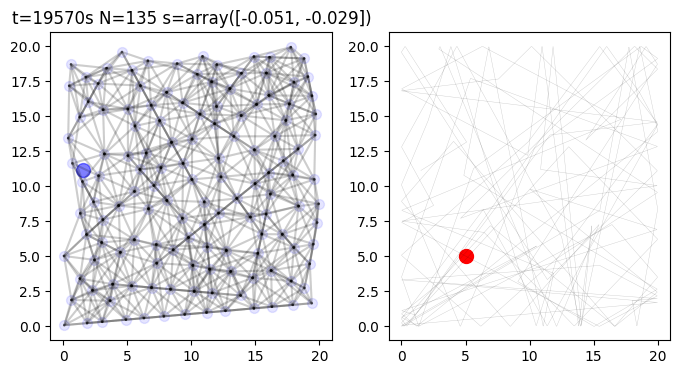

In [3]:
p = [5, 5]

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*np.array(space.get_position()).T, s=100, color="blue", alpha=0.5)
plt.scatter(*np.array(space.get_centers()).T, s=50, color="blue", alpha=0.1)
#plt.scatter(*p, s=100, c='r')
for edge in space.make_edges():
    plt.plot((edge[0][0], edge[1][0]), (edge[0][1], edge[1][1]),
                                  alpha=0.1, color="black")


plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.title(f"t={t}s N={len(space)} {s=}")

plt.subplot(122)
plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.2)
plt.scatter(*p, s=100, c='r')
plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.show()

In [4]:
conn = space.get_connectivity()

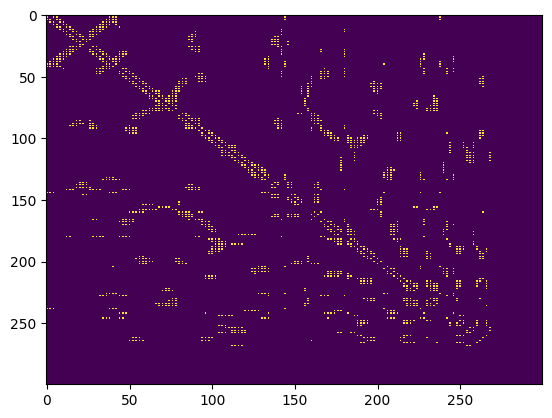

In [17]:
plt.imshow(conn, interpolation="nearest", aspect="auto");

In [12]:
conn[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## GC plot

In [153]:
N = 300

gc = pclib.GridLayerSq(sigma=0.01, speed=0.5, bounds=[-1, 1, -1, 1])

# random walk
speed = 0.08
size = 10.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|████████████████████████████████████████████| 100000/100000 [00:00<00:00, 353123.37it/s]
2025-02-18 03:11:36 | 


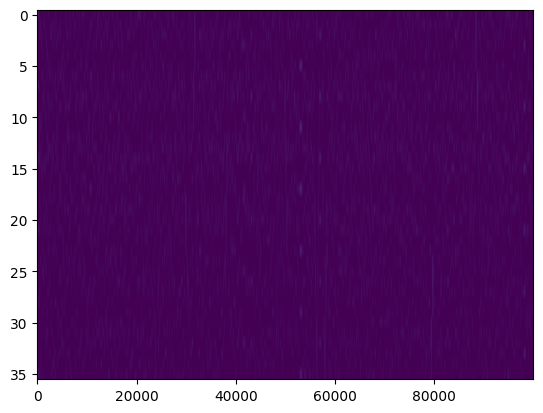

In [154]:
plt.imshow(activity[:, :], aspect="auto");

In [54]:
colrs = plt.cm.rainbow(len(activity))

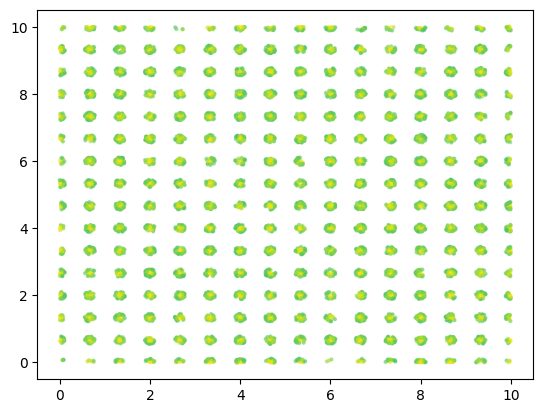

In [155]:
asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=asum, s=np.where(asum>0.02, 4, 0), alpha=0.5);


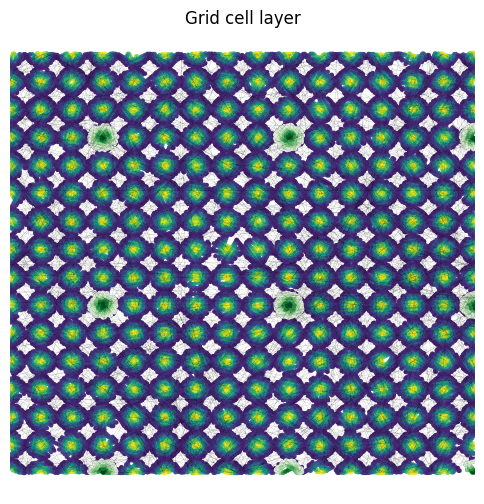

In [161]:
plt.figure(figsize=(6, 6))
plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
            s=np.where(activity[:, :].sum(axis=0)>0.1, 5, 0),
            alpha=0.9, cmap="viridis")
plt.scatter(*np.array(points[1:]).T, c=activity[3, :], 
            s=np.where(activity[3, :]>0.1, 5, 0),
            alpha=0.9, cmap="Greens")

plt.axis("off")
plt.xlim((0, size))
plt.xlim((0, size))

plt.title("Grid cell layer")

plt.show()

## hex

In [19]:

gc = pclib.GridLayerHex(sigma=0.04, speed=0.6)

# random walk
speed = 0.08
size = 20.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 200_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:00<00:00, 394556.01it/s]
2025-02-17 20:55:41 | 


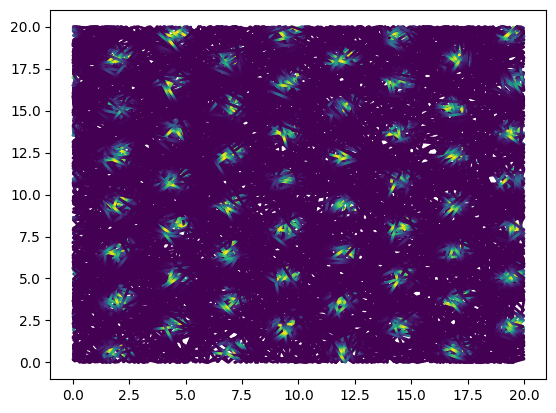

In [28]:
#asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=activity[0], s=1, alpha=1.)
plt.show()


## pcnn

100%|███████████████████████████████████████████████| 100000/100000 [13:37<00:00, 122.29it/s]
2025-02-18 03:04:10 | 


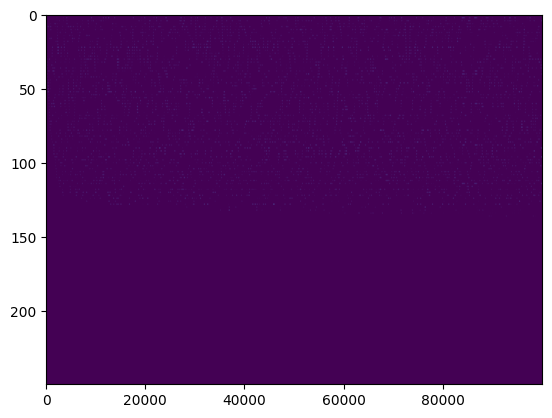

In [123]:
N = 250

local_scale = 0.02
gcn = pclib.GridNetworkSq([
            pclib.GridLayerSq(sigma=0.04, speed=1.*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.8*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.7*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.5*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.3*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.2*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.1*local_scale)])

pcnn = pclib.PCNN(N=N,
                  Nj=len(gcn),
                  gain=10.0,
                  offset=1.,
                  clip_min=0.01,
                  threshold=0.3,
                  rep_threshold=0.9,
                  rec_threshold=1.0,
                  min_rep_threshold=0.99,
                  xfilter=gcn,
                  tau_trace=2.0,
                  name="2D")

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=N,
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])



# random walk
speed = 2.
size = 200

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((N, tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    brain(s, 0., 0., False)
    activity[:, t] = brain.get_representation_fine()
    
    old_point = points[-1]

plt.imshow(activity[:, :], aspect="auto");
logger()

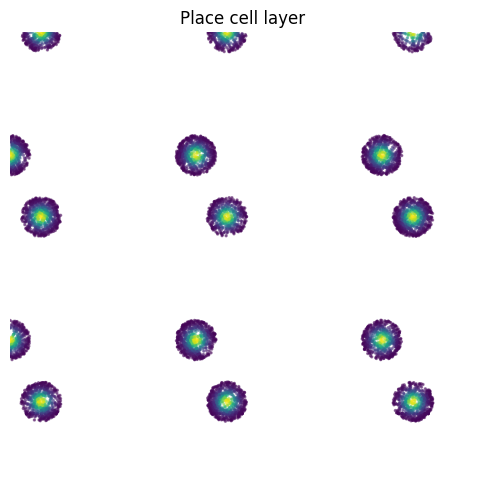

In [157]:
plt.figure(figsize=(6, 6))
#plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
#plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
#            s=np.where(activity[:, :].sum(axis=0)>0.01, 2, 0),
#            alpha=0.9, cmap="viridis")

# cell 1 
plt.scatter(*np.array(points[1:]).T, c=activity[12, :]+activity[22, :], 
            s=np.where((activity[12, :]+activity[22, :])>0.01, 2, 0.),
            alpha=0.5, cmap="viridis")

# cell 2
#plt.scatter(*np.array(points[1:]).T, c=activity[50, :], 
#            s=np.where(activity[50, :]>0.01, 2, 0.1),
#            alpha=0.7, cmap="viridis")


plt.scatter(*np.array(centers).T, color="black")
plt.xlim((0, size))
plt.ylim((0, size))
plt.axis("off")

plt.title("Place cell layer")

plt.show()

In [124]:
centers = brain.get_space_fine_centers()

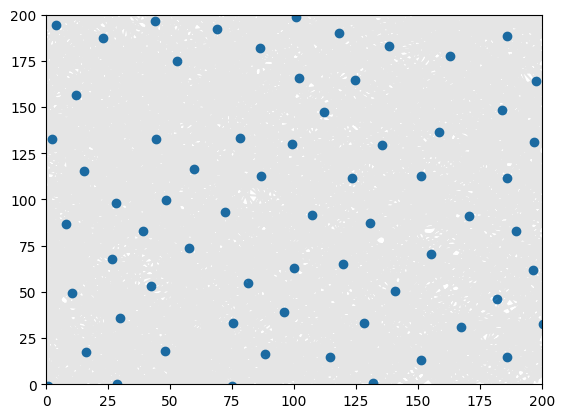

In [125]:
plt.plot(*np.array(points).T, "k-", alpha=0.1)
plt.scatter(*np.array(centers).T)
plt.xlim((0, size))
plt.ylim((0, size))
plt.show()

In [131]:
brain.get_space_fine_count()

69